In [1]:
%pylab inline
# %load_ext autoreload
# %autoreload 2
import jax
import jax.numpy as jnp
import jax_cosmo as jc


from numpyro.handlers import seed, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
'unset XLA_FLAGS'

from jax.config import config
config.update("jax_enable_x64", True)



from functools import partial

Populating the interactive namespace from numpy and matplotlib


/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-2.7.0+py3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.8) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
from sbi_lens.simulator.LogNormal_field import lensingLogNormal

In [3]:
n_z_bins=5

In [4]:
m_data=np.load("data/map_gaussian_tomo_with_noise.npy")

## Create fiducial and plot results

In [5]:
from sbi_lens.simulator.utils import get_reference_sample_posterior_full_field, get_reference_sample_posterior_power_spectrum, get_samples_and_scores

In [6]:
samples_ps = get_reference_sample_posterior_power_spectrum(    
    Omega_c=0.3,
    sigma8=0.8,
    run_mcmc=True,
    N=128,
    map_size=5,
    gals_per_arcmin2=10,
    sigma_e=0.26,
    m_data=m_data,
    num_results=30_000,
    key=jax.random.PRNGKey(3))

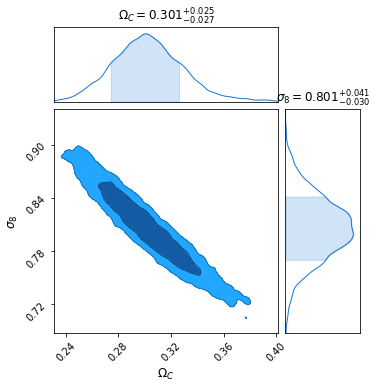

In [7]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

c.add_chain(np.stack([samples_ps[:,0], samples_ps[:,1]],axis=1), parameters=["$\Omega_C$", "$\sigma_8$"], name='PS')
fig = c.plotter.plot(figsize="column")

